# Attention tokens

In [1]:
import torch
from transformer_lens import HookedTransformer, SVDInterpreter

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
import random
import numpy as np
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from rich import print
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from transformer_lens.utils import Slice
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
def decompose_head(cache, l, h, pos=None):
    start, end = 0, len(cache['q', l][0])
    if pos is not None:
        start, end = pos
    q = cache['q', l][:, start:end, h, :]
    k = cache['k', l][:, start:end, h, :]
    v = cache['v', l][:, start:end, h, :]
    return torch.stack([q, k, v])

def project_attn(cache, l, h, mlp=True, **kwargs):
    OV = cache.model.OV[l, h]
    mlp_in = model.W_in[l]
    mlp_out = model.W_out[l]

    cs = decompose_head(cache, l, h, **kwargs)
    proj_A = torch.einsum('c b i h, d h -> c b i d', cs, OV.A)
    proj_B = torch.einsum('c b i d, h d -> c b i d', proj_A, OV.B)
    out = proj_B
    if mlp:
        mlped = torch.einsum('c b i d, d j -> c b i j', proj_B, mlp_in)
        mlped_out = torch.einsum('c b i j, j d -> c b i d', mlped, mlp_out)
        out = mlped_out
    return out

def head2logits(cache, l, h, **kwargs):
    projections = project_attn(cache, l, h, **kwargs)
    logits = cache.model.unembed(projections)
    return logits

In [193]:
def head2preds(cache, hp, l, h, k=1):
    OV = cache.model.OV[l, h]
    proj_A = torch.einsum('b n m h, d h -> b n m d', hp, OV.A)
    proj_B = torch.einsum('b n m d, h d -> b n m d', proj_A, OV.B)
    out = proj_B
    logits = cache.model.unembed(out[0])
    preds = torch.topk(logits, k, dim=-1).indices
    return preds

def parse_tokens(tokens):
    for i in range(len(tokens)):
        for j in range(len(tokens[i])):
            t = tokens[i][j]
            if t == '\n':
                tokens[i][j] = '<nl>'
            if t == ' ':
                tokens[i][j] = '<sp>'
            if t == '\t':
                tokens[i][j] = '<tab>'
            if t == '<|endoftext|>':
                tokens[i][j] = 'EOS'
    return tokens

def calculate_attention_tokens(cache, layer, head, **kwargs):
    q, k, v = decompose_head(cache, layer, head)
    hp = q.unsqueeze(2) * k.unsqueeze(1)
    preds = head2preds(cache, hp, layer, head, **kwargs)
    str_preds = parse_tokens([
        cache.model.to_str_tokens(p) 
        for p in preds
    ])
    # Create a unique list of tokens, maintaining the order they first appear
    unique_tokens = {}
    for i in range(0, len(str_preds)):
        for j in range(i + 1):
            token = str_preds[i][j]
            if token not in unique_tokens:
                unique_tokens[token] = len(unique_tokens)
    
    sequence_length = len(str_preds)
    
    token_matrix = torch.full((sequence_length, sequence_length), -1).to(device)
    for i in range(sequence_length):
        for j in range(i + 1):
            token = str_preds[i][j]
            token_matrix[i, j] = unique_tokens[token]

    return token_matrix, unique_tokens

def plot_attention_head(cache, layer, head, cmap='Inferno', **kwargs):
    print(f'Plotting attention head {head} at layer {layer}')
    patterns = cache['attn', layer][:, head, :, :]
    sequence_length = patterns.shape[-1]
    pattern = patterns.mean(dim=0)
    token_matrix, attention_tokens = calculate_attention_tokens(cache, layer, head, **kwargs)
    attention_token_labels = list(attention_tokens.keys())
    
    print(f'Sequence length: {sequence_length}; Unique tokens: {len(attention_tokens)}')
    print(f'Unique tokens: {attention_token_labels}')

    fig = px.imshow(
        token_matrix.cpu(),
        color_continuous_scale=cmap,
        color_continuous_midpoint=0.5,
        title=f'Attention head {head} at layer {layer}',
    )

    input_tokens = parse_tokens(
        [cache.model.to_str_tokens(random.choice(cache.prompts))]
    )[0]

    min_opacity = 0.3
    for i in range(sequence_length):
        fig.add_annotation(x=-1, y=i, text=input_tokens[i], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='black'))
        fig.add_annotation(x=i, y=sequence_length, text=input_tokens[i], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='black'))
        for j in range(i + 1):
            text = attention_token_labels[int(token_matrix[i, j].item())]
            opacity = max(min(pattern[i, j].item() + min_opacity, 1), min_opacity)
            fig.add_annotation(
                x=j,
                y=i,
                text=text,
                textangle=-45,
                showarrow=False,
                font=dict(color="white"),
                opacity=opacity,
            )

            if pattern[i, j] > min_opacity:
                fig.add_shape(
                    type="rect",
                    x0=j-0.5,
                    y0=i-0.5,
                    x1=j+0.5,
                    y1=i+0.5,
                    line=dict(color="white", width=2),
                    fillcolor="rgba(0, 0, 0, 0)",
                )
    
    fig.update_coloraxes(showscale=False)
    fig.update_layout(
        width=1200, height=1200,
        plot_bgcolor='white',
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False, autorange='reversed'),
    )

    return fig

In [114]:
def run_prompt(model, *prompts):
    _, cache = model.run_with_cache(list(prompts))
    cache.prompts = list(prompts)
    return cache

def plot_prompts(cache, l, h):
    fig = plot_attention_head(cache, l, h, cmap='viridis')
    return fig

In [115]:
cache = run_prompt(model, 'John was two years older than Mary. Who was born first? John was born before Mary')
cache.prompts

['John was two years older than Mary. Who was born first? John was born before Mary']

Plotting attention head 1 at layer 0

Sequence length: 14; Unique tokens: 16

Unique tokens: [' the', '12', ' of', ',', 'e', '<nl>', 'gp', 'st', ' in', 'tg', ' a', '80', 'Dim', 'x', ' and', 
'c']

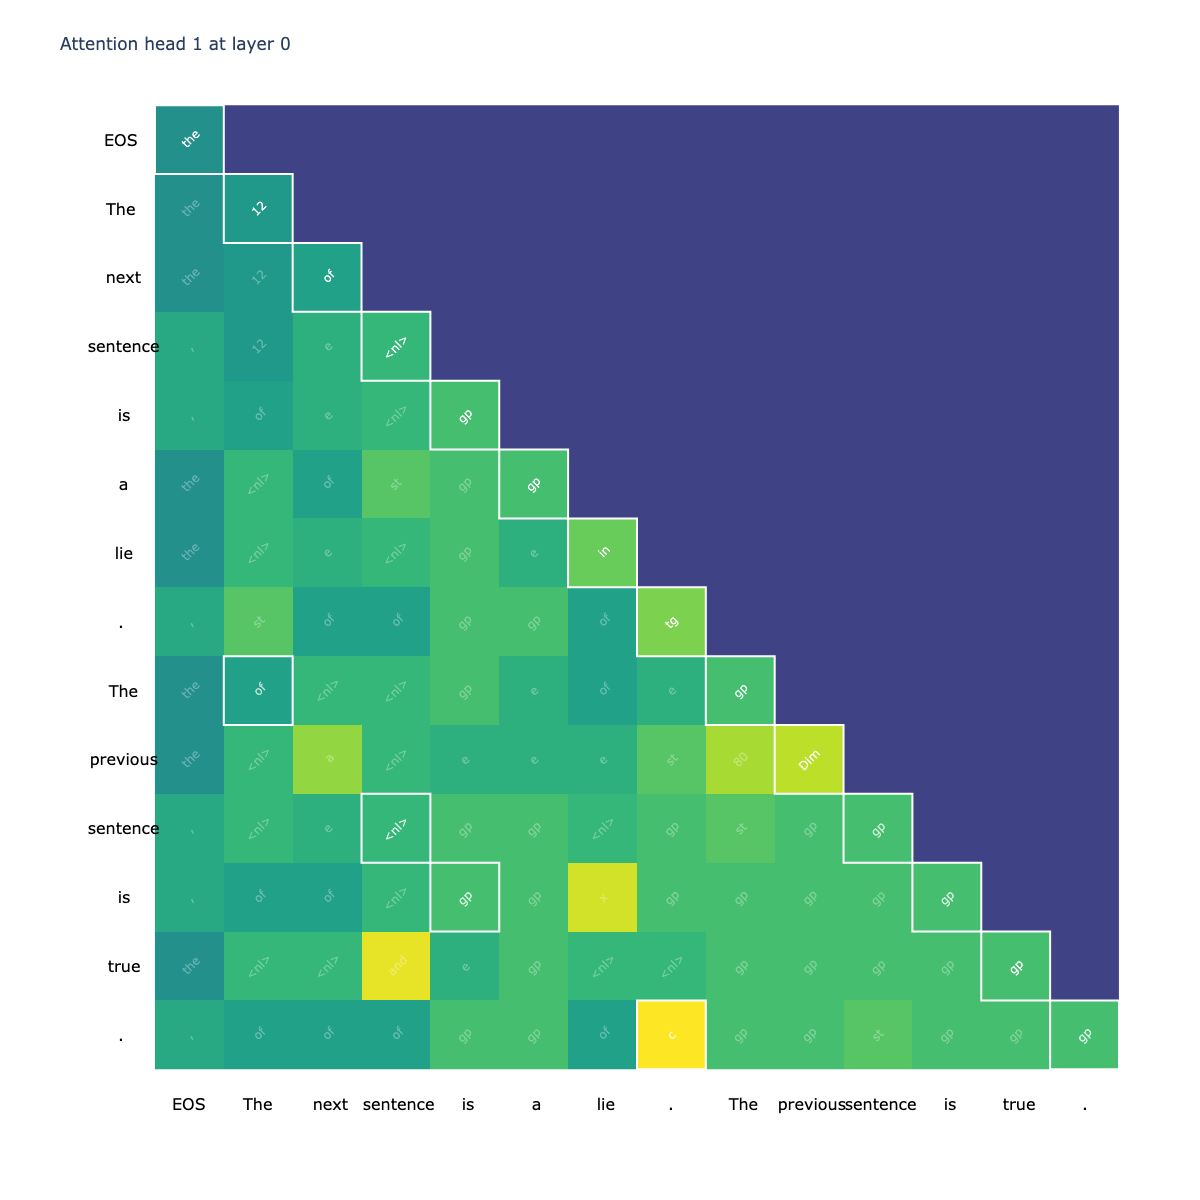

In [185]:
fig = plot_prompts(cache, 0, 1)
fig.show()

Plotting attention head 3 at layer 0

Sequence length: 14; Unique tokens: 10

Unique tokens: [',', ' the', ' veter', ' local', ' loose', '.', ' other', ' and', 'ailability', 'ult']

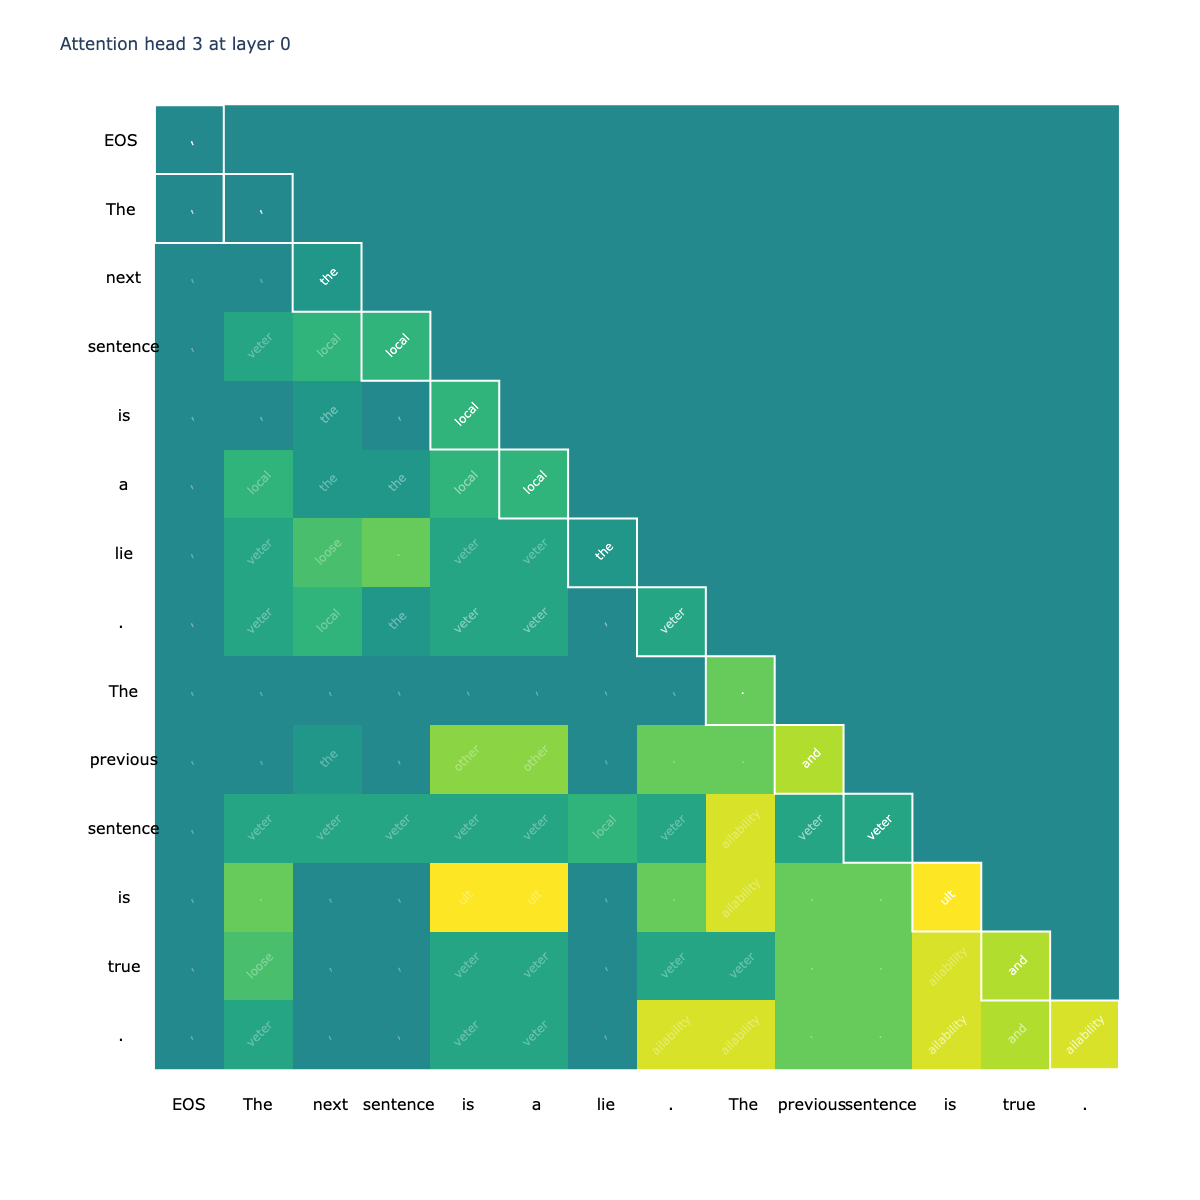

In [195]:
cache = run_prompt(model, "The next sentence is a lie. The previous sentence is true.")
fig = plot_prompts(cache, 0, 3)
fig.show()

Plotting attention head 6 at layer 0

Sequence length: 19; Unique tokens: 13

Unique tokens: [' to', 'enegger', ' and', ',', 'red', 'able', ' the', ' score', 'ratom', ')</', ' future', 
'itably', 'uls']

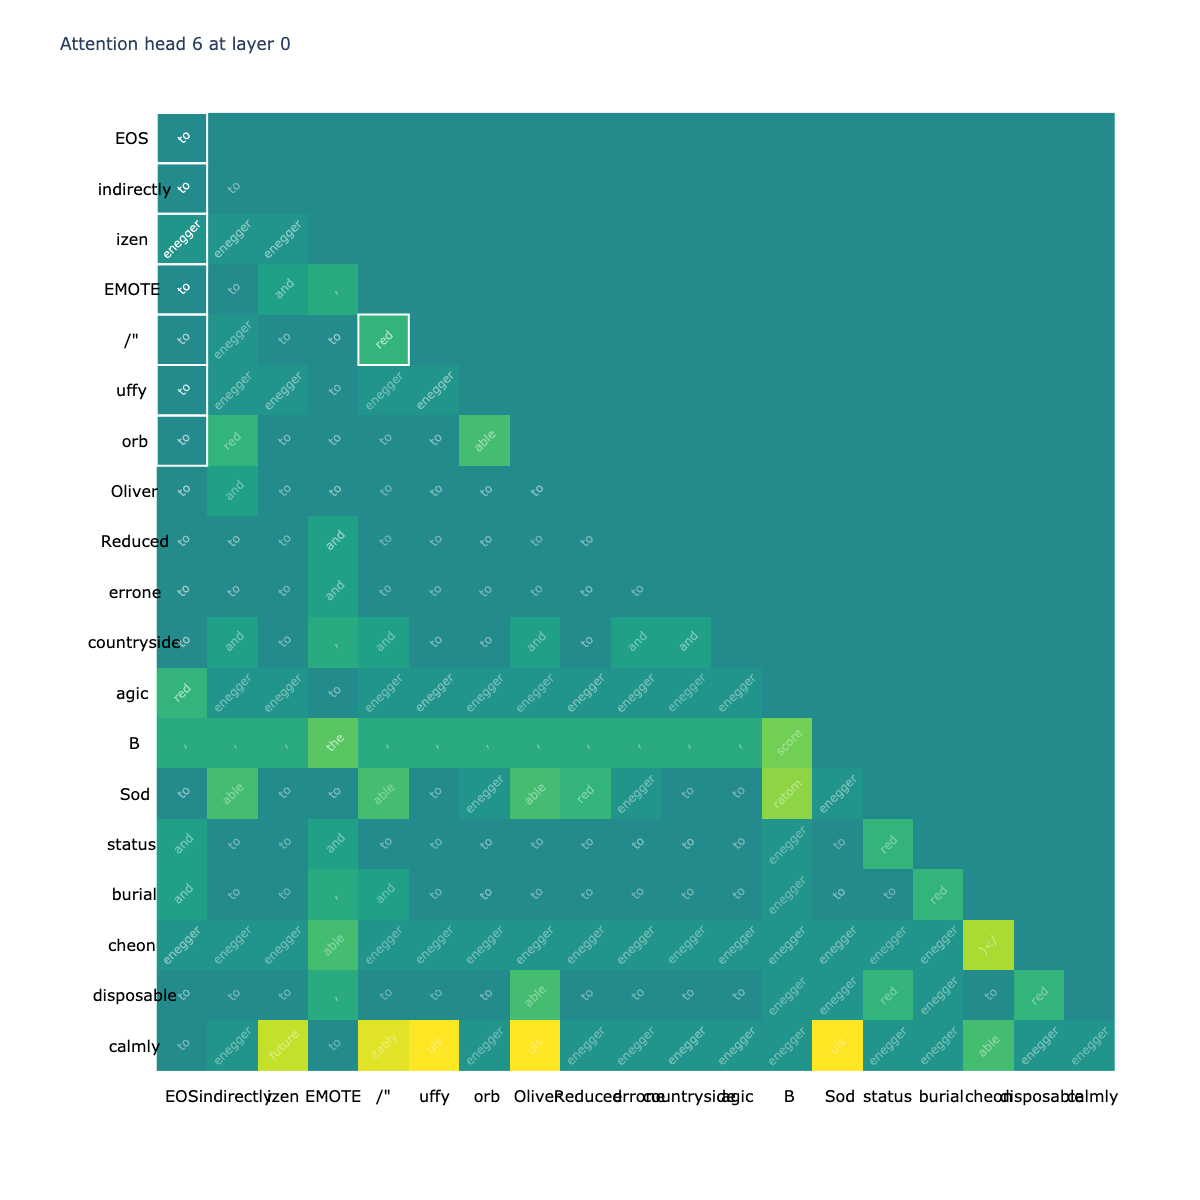

In [194]:
random_tokens = torch.randint(0, 50257, (1, 18)).to(device)
random_prompt = model.to_str_tokens(random_tokens)
random_cache = run_prompt(model, ''.join(random_prompt))
fig = plot_prompts(random_cache, 0, 6)
fig.show()

In [189]:
data = []
for l in range(12):
    for h in range(12):
        fig, unique_tokens = plot_prompts(cache, l, h)
        fig.write_image(f'./images_4/layer_{l}_head_{h}.png')
        data.append({'layer': l, 'head': h, 'unique_tokens': unique_tokens})

import json

with open('./images_4/data.json', 'w') as f:
    json.dump(data, f)

Plotting attention head 0 at layer 0

Sequence length: 14; Unique tokens: 4

Unique tokens: [' the', ' in', ',', 'orn']

ValueError: too many values to unpack (expected 2)

In [ ]:
import pandas as pd

df = pd.read_json('./images_4/data.json')
df

In [ ]:
df['Unique_Tokens_Count'] = df['unique_tokens'].apply(lambda x: len(x))
df

In [ ]:
df_sorted = df.sort_values('Unique_Tokens_Count', ascending=False)
df_sorted


In [ ]:
from matplotlib import pyplot as plt

grouped_df = df.groupby('layer')

fig, ax = plt.subplots()
for layer, group in grouped_df:
    group.plot(x='head', y='Unique_Tokens_Count', kind='line', ax=ax, label=f'Layer {layer}')

plt.title('Unique Token Count by Head Index')
plt.xlabel('Head Index')
plt.ylabel('Unique Token Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
unique_tokens = set()
for tokens in df['unique_tokens']:
    unique_tokens.update(tokens)

print(f"Count of unique tokens: {len(unique_tokens)}")


In [ ]:
# Get the unique tokens for each head
head_tokens = df['unique_tokens']

seen = {}
duplicates = {}

for i, tokens in enumerate(head_tokens):
    for token in tokens:
        if token in seen:
            if token in duplicates:
                duplicates[token].append(i)
            else:
                duplicates[token] = [seen[token], i]
        else:
            seen[token] = i

from pprint import pprint

pprint(len(duplicates))

open questions
---

- are head tokens consistent across inputs?
- do head token counts remain consistent across inputs?
  - plot graphs for this
- which tokens are shared across all heads if any?
- are shared tokens common across inputs?
- how many tokens are used per row?

improvements
---
- plot Q in the top diagonal
- add border to cells over an attention score threshold
- plot resid stream predictions
- plot K instead of Q*K
  - if useful, add diagonal for Q*K at current token
- plot averaged inputs instead of individual prompts
- plot grid of attention token graphs
  - needs to run head calculations in parellel
- craft prompt for gpt to analyse patterns in attention tokens

In [ ]:
cache = run_prompt(model, "John was two years older than Mary. Who was born first? John was born before Mary")
fig, _ = plot_prompts(cache, 0, 0)
fig.show()

In [ ]:
cache = run_prompt(model, "Paris is the capital of France. London is the capital of England.")
fig, _ = plot_prompts(cache, 4, 11)
fig.show()